In [117]:
!pip install pandas numpy
!pip install matplotlib
!pip install scikit-learn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import os 
import re
import matplotlib.pyplot as plt

In [118]:
main_df = pd.read_csv('CJQ06.20260202004354.csv')
main_df = main_df.drop(["STATISTIC","C02480V03003","C02481V03160","TLIST(Q1)","UNIT"],axis=1)
pattern = r'\((\d{2})\)'
main_df["Year"] = main_df["Quarter"].str.slice(0,4)
main_df = main_df.drop("Quarter",axis=1)
main_df = main_df.groupby(
    ["Year", "Garda Division", "Type of Offence"],  
    as_index=False  
)["VALUE"].sum()
main_df = main_df.loc[main_df["Type of Offence"].str.contains(pattern, regex=True)]




C:\Users\downe\AppData\Local\Temp\ipykernel_448\2037942219.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  main_df = main_df.loc[main_df["Type of Offence"].str.contains(pattern, regex=True)]


In [119]:
main_df

,Year,Garda Division,Type of Offence,VALUE
5,2003,Cavan/Monaghan Garda Division,"Attempts/threats to murder, assaults, harassme...",596.0
8,2003,Cavan/Monaghan Garda Division,Burglary and related offences (07),480.0
10,2003,Cavan/Monaghan Garda Division,Controlled drug offences (10),191.0
13,2003,Cavan/Monaghan Garda Division,Damage to property and to the environment off...,651.0
16,2003,Cavan/Monaghan Garda Division,Dangerous or negligent acts (04),866.0
...,...,...,...,...
54721,2025,Wicklow Garda Division,Road and traffic offences (14),688.0
54727,2025,Wicklow Garda Division,"Robbery, extortion and hijacking offences (06)",24.0
54728,2025,Wicklow Garda Division,Sexual offences (02),64.0
54731,2025,Wicklow Garda Division,Theft and related offences (08),1349.0


In [120]:
main_df["Type of Offence"] = main_df["Type of Offence"].str.replace(r"\s\(\d{2}\)$", "", regex=True)
crimes = main_df["Type of Offence"].unique()


In [121]:
unique_division = main_df['Garda Division'].unique().tolist()
#replacing "/" with "-" to make writing filepaths easier
unique_division = [div.replace('/', '-') for div in unique_division]
main_df['Garda Division'] = main_df['Garda Division'].str.replace('/', '-')
#main_df.to_csv("cleaned_df.csv",index=False)
    


In [122]:
#seperate our big dataframe into a set of small dataframes based on each garda division
sub_dfs = {} # key = garda division, value = dataframe
for division in unique_division:
    sub_df = main_df.loc[main_df["Garda Division"]==division]
    sub_dfs[division] = sub_df


In [123]:
#writing each sub_df to its own individual csv file for future reference and ease
curr_dir = os.getcwd()
if not os.path.exists(os.path.join(curr_dir,"counties")):
    os.mkdir(os.path.join(curr_dir,"counties"),mode=0o755)

for division in sub_dfs.keys():
    division_path = os.path.join(curr_dir, "counties", division)
    os.makedirs(division_path, exist_ok=True)

    file_path = os.path.join(division_path, f"{division}_crime.csv")
    sub_dfs[division].to_csv(file_path, index=False)

In [124]:
dfs = []
for file in os.listdir("counties"):
    dfs.append(pd.read_csv(os.path.join(f"counties\\{file}",f"{file}_crime.csv")))
    

In [125]:
## Make a figure of 16 graphs, each containing information as to crime in each category over the years
county_crime_information = {}

for df in dfs:
    crimes_since_2003 = []
    for crime in crimes:
        y = df[df["Type of Offence"] == f"{crime}"]["VALUE"]
        x =  df[df["Type of Offence"] == f"{crime}"]["Year"]
        temp = [x,y]
        crimes_since_2003.append(temp)
    county_crime_information[df["Garda Division"][0]] = crimes_since_2003



In [126]:
for county in county_crime_information:

    fig, ax = plt.subplots(nrows = 4, ncols = 4,figsize=(16,16))
    fig.suptitle(f"{county}", fontsize=20, y=0.95) 


    for i,crime in enumerate(county_crime_information[county]):
        row = i//4
        col = i%4
        ax[row,col].plot(crime[0], crime[1], marker='o', linestyle='-', markerfacecolor='red')
        ax[row,col].set_title(f"{crimes[i]}",fontsize=10)
        ax[row,col].set_xlabel("Year")
        ax[row,col].set_ylabel("Number of Incidents")
        ax[row,col].grid(True)
        ax[row,col].tick_params(axis='x',rotation=45)


    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space at the top for suptitle
    plt.savefig(f"counties/{county}/{county}_crimes.jpg")
    plt.close(fig)


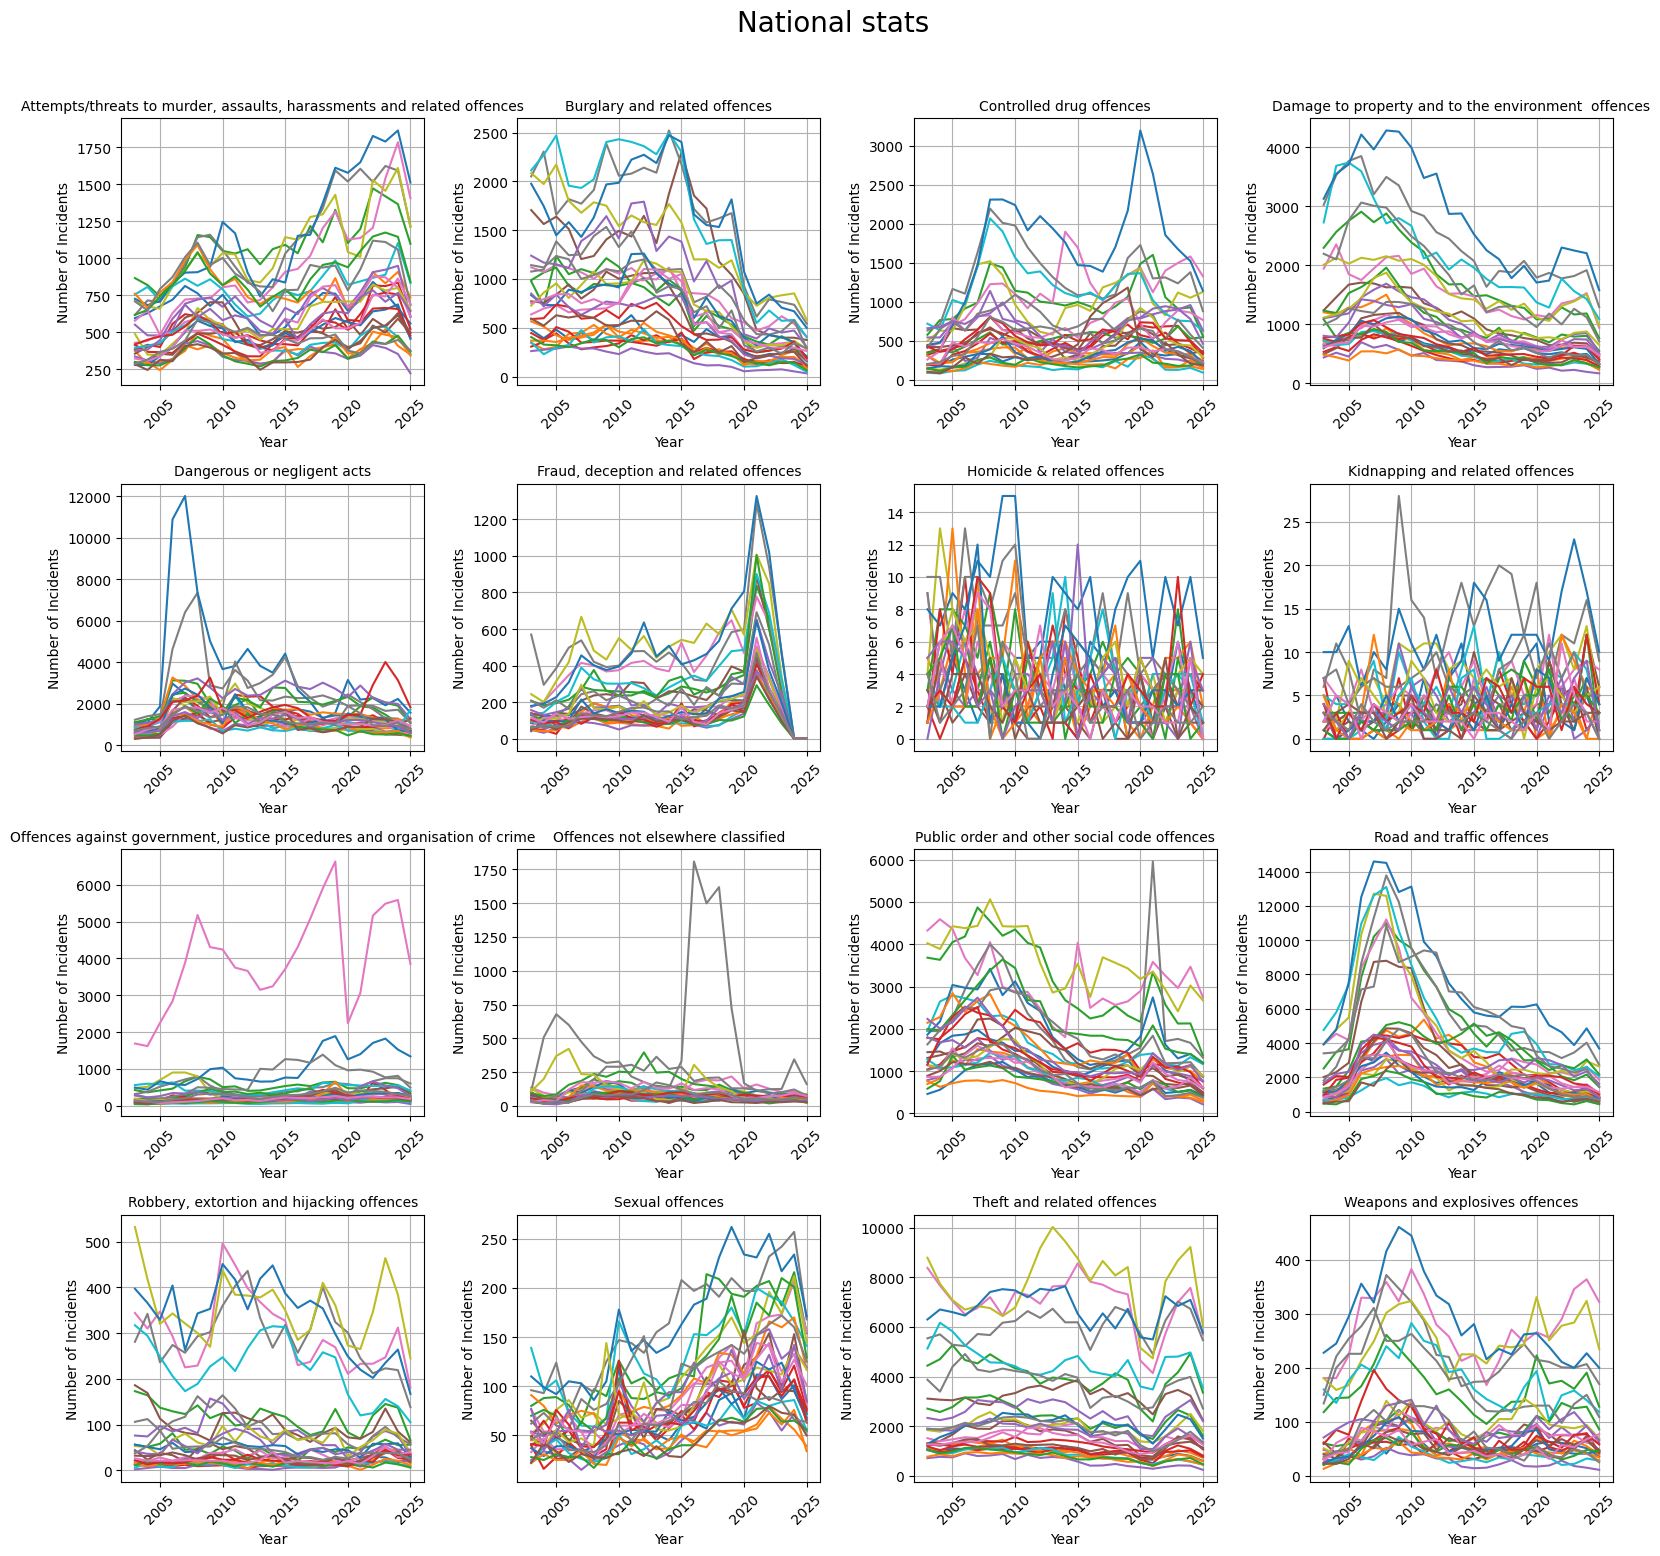

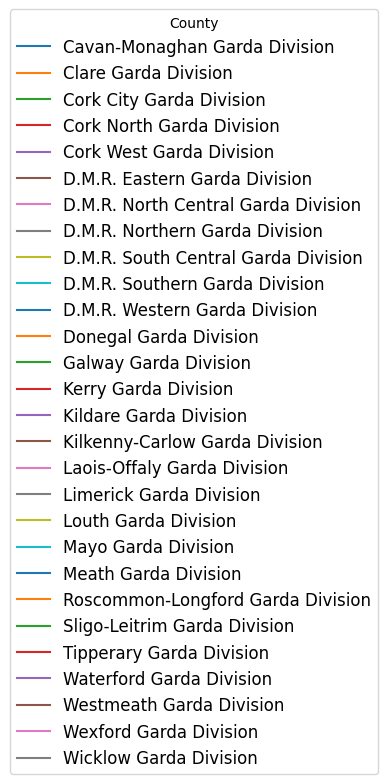

In [127]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16,16))
fig.suptitle("National stats", fontsize=20, y=0.97)

for county in county_crime_information:
    for i, crime in enumerate(county_crime_information[county]):
        row = i // 4
        col = i % 4
        ax[row, col].plot(crime[0], crime[1], linestyle='-')  # no label
        ax[row, col].set_title(f"{crimes[i]}", fontsize=10)
        ax[row, col].set_xlabel("Year")
        ax[row, col].set_ylabel("Number of Incidents")
        ax[row, col].grid(True)
        ax[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("national_stats.png")
plt.show()


fig_legend = plt.figure(figsize=(4,6)) # creating a second figure to store our legend
ax_leg = fig_legend.add_subplot(111) # first figure, one col,one row

handles = [] # handle =plotted object
for county in county_crime_information:
    line, = ax_leg.plot([], [], label=county) #creating an empty plot with some empty data
    handles.append(line)

ax_leg.legend(handles=handles, loc='center', fontsize=12, title="County") # creating our legend
ax_leg.axis('off')  # disabling our axis
plt.savefig("legend_only.png", bbox_inches='tight')
plt.show()


In [128]:
# Sort by County, Type of Offence, Year
main_df = main_df.sort_values(['Garda Division','Type of Offence','Year'])

# Group by county/division and type of offence
main_df['pct_change'] = main_df.groupby(['Garda Division','Type of Offence'])['VALUE'].pct_change() * 100


In [129]:
main_df

,Year,Garda Division,Type of Offence,VALUE,pct_change
5,2003,Cavan-Monaghan Garda Division,"Attempts/threats to murder, assaults, harassme...",596.0,NaN
2385,2004,Cavan-Monaghan Garda Division,"Attempts/threats to murder, assaults, harassme...",630.0,5.704698
4765,2005,Cavan-Monaghan Garda Division,"Attempts/threats to murder, assaults, harassme...",676.0,7.301587
7145,2006,Cavan-Monaghan Garda Division,"Attempts/threats to murder, assaults, harassme...",721.0,6.656805
9525,2007,Cavan-Monaghan Garda Division,"Attempts/threats to murder, assaults, harassme...",814.0,12.898752
...,...,...,...,...,...
45219,2021,Wicklow Garda Division,Weapons and explosives offences,38.0,-32.142857
47599,2022,Wicklow Garda Division,Weapons and explosives offences,34.0,-10.526316
49979,2023,Wicklow Garda Division,Weapons and explosives offences,49.0,44.117647
52359,2024,Wicklow Garda Division,Weapons and explosives offences,43.0,-12.244898


In [130]:
#Plotting the percentage change in crime for 2025 
dfs_2025 = []
main_df_2025 = main_df.loc[main_df["Year"] == "2025"]
main_df_2025 = main_df.loc[main_df["Year"] == "2025"].copy()  # make an explicit copy
main_df_2025["pct_change"] = main_df_2025["pct_change"].replace([np.inf, -np.inf], np.nan)

main_df_2025 = main_df_2025.dropna()
dfs_2025 = [main_df_2025[main_df_2025["Garda Division"]==i] for i in main_df_2025["Garda Division"].unique()]



In [131]:
copy_2025 = main_df_2025.drop("Garda Division",axis=1)
copy_2025 = main_df_2025.groupby(
    ["Year","Type of Offence"],  
    as_index=False  
)["pct_change"].mean()
x = copy_2025["Type of Offence"]
y = copy_2025["pct_change"]
plt.xlabel("% Change since 2024")
plt.title("National average change in crime since 2024")
plt.ylabel("Offence type")
plt.subplots_adjust(left=0.35)
plt.barh(x,y)
plt.tight_layout()
plt.savefig(f"national_barh.png", bbox_inches="tight")
plt.close()

In [ ]:
for df in dfs_2025:
    x = df["Type of Offence"]
    y = df["pct_change"]
    plt.figure(figsize=(16, 12))  # (width, height) in inches

    plt.title(df["Garda Division"].iloc[0])
    plt.xlabel("% Change since 2024")
    plt.ylabel("Offence type")
    plt.subplots_adjust(left=0.35)
    plt.barh(x,y)
    plt.tight_layout()
    division = df["Garda Division"].iloc[0]
    plt.savefig(f"counties/{division}/{division}_barh.png", bbox_inches="tight")
    plt.close()


In [133]:
# Pivot to get divisions x offence types
feature_df = main_df.pivot_table(
    index="Garda Division",            # rows = divisions
    columns="Type of Offence",         # columns = crime types
    values="VALUE",                    # counts
    aggfunc='sum',                     # sum across years
    fill_value=0                       # fill missing offences with 0
)



In [134]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_df)


In [135]:

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

feature_df['Cluster'] = clusters 


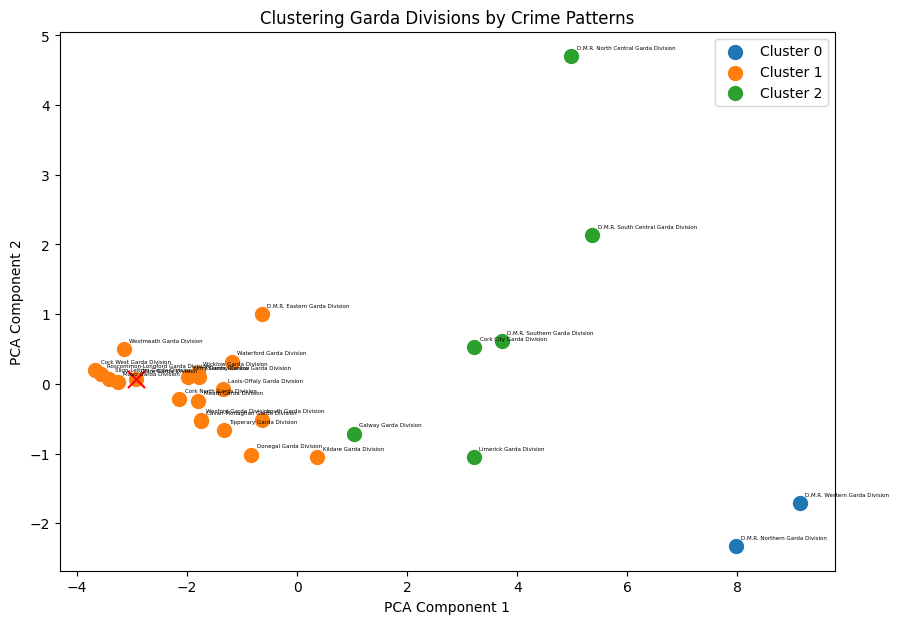

In [136]:

# Reduce dimensions to 2D for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10,7))
for cluster in range(k):
    idx = feature_df['Cluster'] == cluster
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'Cluster {cluster}', s=100)

for i, division in enumerate(feature_df.index):
    if(division == "Clare Garda Division"):
        plt.scatter(X_pca[i, 0], X_pca[i, 1], c='red', s=150, marker='x')  # Highlight Clare Garda Division with a red x
    plt.text(X_pca[i, 0]+0.1, X_pca[i, 1]+0.1, division, fontsize=4)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clustering Garda Divisions by Crime Patterns')
plt.legend()
plt.show()


In [137]:
# Look at average crime profile per cluster
feature_df.groupby('Cluster').mean()


Type of Offence,"Attempts/threats to murder, assaults, harassments and related offences",Burglary and related offences,Controlled drug offences,Damage to property and to the environment offences,Dangerous or negligent acts,"Fraud, deception and related offences",Homicide & related offences,Kidnapping and related offences,"Offences against government, justice procedures and organisation of crime",Offences not elsewhere classified,Public order and other social code offences,Road and traffic offences,"Robbery, extortion and hijacking offences",Sexual offences,Theft and related offences,Weapons and explosives offences
Cluster,,,,,,,,,,,,,,,,
0,26469.5,37182.500000,34802.500000,61729.50,71458.50,10752.000000,169.000000,282.500000,17704.50,6595.500000,48863.00,154487.000000,7187.50,3779.500000,146486.5,5922.500000
1,11757.5,12329.850000,9547.400000,16232.35,29056.65,3224.000000,66.250000,69.800000,4458.05,1650.800000,24455.95,46664.900000,769.65,1558.450000,32642.4,1381.000000
2,21803.5,24498.166667,21387.333333,38814.00,35724.50,7600.333333,93.166667,137.833333,24259.50,2694.166667,60157.00,112060.666667,4352.00,2705.666667,112672.5,4350.833333
